In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    confusion_matrix,
    classification_report,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score
)
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, Callback

In [3]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [4]:
# Data Loading and Preprocessing 
def load_and_preprocess_data(filepath):
    # Load the dataset
    df = pd.read_csv(filepath)

    # Separate features and target
    X = df.drop('stroke', axis=1)
    y = df['stroke']

    # Split the data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, stratify=y
    )

    # Scale the features
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    return X_train_scaled, X_test_scaled, y_train, y_test, scaler



In [5]:
# Create ANN Model
def create_ann_model(input_shape):
    model = Sequential([
        Dense(64, activation='relu', input_shape=(input_shape,), kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.3),
        Dense(32, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)),
        Dropout(0.2),
        Dense(16, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.001),
        loss='binary_crossentropy',
        metrics=['accuracy']
    )

    return model

In [6]:
# # Custom Callback to Track Epoch Training Time
# class EpochTimeCallback(Callback):
#     def __init__(self):
#         super().__init__()
#         self.epoch_times = []
#         self.epoch_start_time = None
# 
#     def on_epoch_begin(self, epoch, logs=None):
#         self.epoch_start_time = time.time()
# 
#     def on_epoch_end(self, epoch, logs=None):
#         epoch_end_time = time.time()
#         self.epoch_times.append(epoch_end_time - self.epoch_start_time)
class EpochTimeCallback(Callback):
    def __init__(self):
        super().__init__()
        self.epoch_times = []  # To store the time for each epoch

    def on_epoch_begin(self, epoch, logs=None):
        self.epoch_start_time = time.time()  # Start time of epoch

    def on_epoch_end(self, epoch, logs=None):
        epoch_end_time = time.time()  # End time of epoch
        epoch_time = epoch_end_time - self.epoch_start_time  # Time taken for the epoch
        self.epoch_times.append(epoch_time)  # Store the time for the epoch

        # You can also log or update other progress information here if required
        print(f"Epoch {epoch + 1} took {epoch_time:.4f} seconds")


In [7]:
# # Training Function
# def train_model(X_train, y_train):
#     # Create model
#     model = create_ann_model(X_train.shape[1])
# 
#     # Early stopping
#     early_stopping = EarlyStopping(
#         monitor='val_loss',
#         patience=10,
#         restore_best_weights=True
#     )
# 
#     # Epoch time tracking callback
#     epoch_time_callback = EpochTimeCallback()
# 
#     # Train the model with tqdm
#     epochs = 50
#     progress_bar = tqdm(range(epochs), desc="Training Progress", unit="epoch")
# 
#     history = model.fit(
#         X_train, y_train,
#         validation_split=0.2,
#         epochs=epochs,
#         batch_size=32,
#         callbacks=[
#             early_stopping,
#             epoch_time_callback,
#             tf.keras.callbacks.LambdaCallback(
#                 on_epoch_end=lambda epoch, logs: progress_bar.set_postfix(
#                     loss=f"{logs.get('loss'):.4f}",
#                     val_loss=f"{logs.get('val_loss'):.4f}"
#                 )
#             )
#         ],
#         verbose=0
#     )
# 
#     return model, history, epoch_time_callback

def train_model(X_train, y_train):
    # Create model
    model = create_ann_model(X_train.shape[1])

    # Early stopping
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True
    )

    # Epoch time tracking callback
    epoch_time_callback = EpochTimeCallback()

    # Train the model with tqdm for progress bar visualization
    epochs = 5
    progress_bar = tqdm(range(epochs), desc="Training Progress", unit="epoch")

    history = model.fit(
        X_train, y_train,
        validation_split=0.2,
        epochs=epochs,
        batch_size=32,
        callbacks=[
            early_stopping,
            epoch_time_callback,
            tf.keras.callbacks.LambdaCallback(
                on_epoch_end=lambda epoch, logs: progress_bar.set_postfix(
                    loss=f"{logs.get('loss'):.4f}",
                    val_loss=f"{logs.get('val_loss'):.4f}",
                    epoch_time=f"{epoch_time_callback.epoch_times[-1]:.4f}"  # Display time for current epoch
                )
            )
        ],
        verbose=0
    )

    return model, history, epoch_time_callback


In [11]:
# # Evaluation Function
# def evaluate_model(model, X_test, y_test, history, epoch_time_callback):
#     # Start overall timing
#     start_time = time.time()
# 
#     # Predictions
#     y_pred_proba = model.predict(X_test)
#     y_pred = (y_pred_proba > 0.5).astype(int)
# 
#     # Calculate total training time
#     total_training_time = time.time() - start_time
# 
#     # Performance Metrics
#     accuracy = accuracy_score(y_test, y_pred)
#     precision = precision_score(y_test, y_pred)
#     recall = recall_score(y_test, y_pred)
#     f1 = f1_score(y_test, y_pred)
# 
#     # Detailed Classification Report
#     class_report = classification_report(y_test, y_pred)
# 
#     # Visualizations
#     plt.figure(figsize=(20, 5))
# 
#     # 1. Loss Curves
#     plt.subplot(141)
#     plt.plot(history.history['loss'], label='Training Loss')
#     plt.plot(history.history['val_loss'], label='Validation Loss')
#     plt.title('Model Loss')
#     plt.xlabel('Epoch')
#     plt.ylabel('Loss')
#     plt.legend()
# 
#     # 2. Accuracy Curves
#     plt.subplot(142)
#     plt.plot(history.history['accuracy'], label='Training Accuracy')
#     plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
#     plt.title('Model Accuracy')
#     plt.xlabel('Epoch')
#     plt.ylabel('Accuracy')
#     plt.legend()
# 
#     # 3. Confusion Matrix
#     plt.subplot(143)
#     cm = confusion_matrix(y_test, y_pred)
#     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
#     plt.title('Confusion Matrix')
#     plt.ylabel('True Label')
#     plt.xlabel('Predicted Label')
# 
#     # 4. Epoch Training Time
#     plt.subplot(144)
#     plt.plot(epoch_time_callback.epoch_times, color='green')
#     plt.title('Time per Epoch')
#     plt.xlabel('Epoch')
#     plt.ylabel('Time (seconds)')
# 
#     plt.tight_layout()
#     plt.show()
# 
#     # Save performance metrics
#     performance_metrics = {
#         'Accuracy': accuracy,
#         'Precision': precision,
#         'Recall': recall,
#         'F1 Score': f1,
#         'Total Training Time (s)': total_training_time,
#         'Average Epoch Time (s)': np.mean(epoch_time_callback.epoch_times),
#         'Classification Report': class_report,
#         'Epoch Times': epoch_time_callback.epoch_times
#     }
# 
#     return performance_metrics
def evaluate_model(model, X_test, y_test, history, epoch_time_callback):
    # Predictions
    y_pred_proba = model.predict(X_test)
    y_pred = (y_pred_proba > 0.5).astype(int)

    # Performance Metrics
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)

    # Total Training Time (sum of epoch times)
    total_training_time = sum(epoch_time_callback.epoch_times)
    average_epoch_time = np.mean(epoch_time_callback.epoch_times)

    # Detailed Classification Report
    class_report = classification_report(y_test, y_pred)

    # Visualizations
    plt.figure(figsize=(20, 5))

    # 1. Loss Curves
    plt.subplot(141)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # 2. Accuracy Curves
    plt.subplot(142)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # 3. Confusion Matrix
    plt.subplot(143)
    cm = confusion_matrix(y_test, y_pred)
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')

    # 4. Epoch Training Time
    plt.subplot(144)
    plt.plot(epoch_time_callback.epoch_times, color='green')
    plt.title('Time per Epoch')
    plt.xlabel('Epoch')
    plt.ylabel('Time (seconds)')

    plt.tight_layout()
    plt.show()


    # Save performance metrics
    performance_metrics = {
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1,
        'Total Training Time (s)': total_training_time,
        'Average Epoch Time (s)': average_epoch_time,
        'Classification Report': class_report,
        'Epoch Times': epoch_time_callback.epoch_times
    }

    return performance_metrics



C:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
Training Progress:   0%|          | 0/50 [00:10<?, ?epoch/s, epoch_time=10.3659, loss=0.5059, val_loss=0.3474]

Epoch 1 took 10.3659 seconds


Training Progress:   0%|          | 0/50 [00:13<?, ?epoch/s, epoch_time=2.5013, loss=0.3464, val_loss=0.3152] 

Epoch 2 took 2.5013 seconds


Training Progress:   0%|          | 0/50 [00:23<?, ?epoch/s, epoch_time=10.1343, loss=0.3167, val_loss=0.3010]

Epoch 3 took 10.1343 seconds


Training Progress:   0%|          | 0/50 [00:28<?, ?epoch/s, epoch_time=5.8029, loss=0.2931, val_loss=0.2874] 

Epoch 4 took 5.8029 seconds


Training Progress:   0%|          | 0/50 [00:32<?, ?epoch/s, epoch_time=3.5471, loss=0.2855, val_loss=0.2812]

Epoch 5 took 3.5471 seconds


Training Progress:   0%|          | 0/50 [00:35<?, ?epoch/s, epoch_time=2.9541, loss=0.2803, val_loss=0.2727]

Epoch 6 took 2.9541 seconds


Training Progress:   0%|          | 0/50 [00:38<?, ?epoch/s, epoch_time=3.2430, loss=0.2704, val_loss=0.2690]

Epoch 7 took 3.2430 seconds


Training Progress:   0%|          | 0/50 [00:45<?, ?epoch/s, epoch_time=6.4990, loss=0.2647, val_loss=0.2610]

Epoch 8 took 6.4990 seconds


Training Progress:   0%|          | 0/50 [00:49<?, ?epoch/s, epoch_time=3.7165, loss=0.2563, val_loss=0.2576]

Epoch 9 took 3.7165 seconds


Training Progress:   0%|          | 0/50 [00:57<?, ?epoch/s, epoch_time=8.0407, loss=0.2528, val_loss=0.2541]

Epoch 10 took 8.0407 seconds


Training Progress:   0%|          | 0/50 [01:02<?, ?epoch/s, epoch_time=5.0101, loss=0.2434, val_loss=0.2519]

Epoch 11 took 5.0101 seconds


Training Progress:   0%|          | 0/50 [01:10<?, ?epoch/s, epoch_time=8.3644, loss=0.2424, val_loss=0.2466]

Epoch 12 took 8.3644 seconds


Training Progress:   0%|          | 0/50 [01:17<?, ?epoch/s, epoch_time=6.5570, loss=0.2391, val_loss=0.2442]

Epoch 13 took 6.5570 seconds


Training Progress:   0%|          | 0/50 [01:20<?, ?epoch/s, epoch_time=3.8836, loss=0.2344, val_loss=0.2407]

Epoch 14 took 3.8836 seconds


Training Progress:   0%|          | 0/50 [01:25<?, ?epoch/s, epoch_time=4.6840, loss=0.2314, val_loss=0.2411]

Epoch 15 took 4.6840 seconds


Training Progress:   0%|          | 0/50 [01:33<?, ?epoch/s, epoch_time=7.8470, loss=0.2303, val_loss=0.2384]

Epoch 16 took 7.8470 seconds


Training Progress:   0%|          | 0/50 [01:36<?, ?epoch/s, epoch_time=3.3625, loss=0.2251, val_loss=0.2342]

Epoch 17 took 3.3625 seconds


Training Progress:   0%|          | 0/50 [01:42<?, ?epoch/s, epoch_time=5.8979, loss=0.2234, val_loss=0.2351]

Epoch 18 took 5.8979 seconds


Training Progress:   0%|          | 0/50 [01:53<?, ?epoch/s, epoch_time=10.4223, loss=0.2165, val_loss=0.2357]

Epoch 19 took 10.4223 seconds


Training Progress:   0%|          | 0/50 [01:59<?, ?epoch/s, epoch_time=5.6878, loss=0.2207, val_loss=0.2309] 

Epoch 20 took 5.6878 seconds


Training Progress:   0%|          | 0/50 [02:08<?, ?epoch/s, epoch_time=9.2641, loss=0.2202, val_loss=0.2290]

Epoch 21 took 9.2641 seconds


Training Progress:   0%|          | 0/50 [02:12<?, ?epoch/s, epoch_time=4.3135, loss=0.2150, val_loss=0.2306]

Epoch 22 took 4.3135 seconds


Training Progress:   0%|          | 0/50 [02:24<?, ?epoch/s, epoch_time=12.2724, loss=0.2131, val_loss=0.2288]

Epoch 23 took 12.2724 seconds


Training Progress:   0%|          | 0/50 [02:29<?, ?epoch/s, epoch_time=4.8945, loss=0.2116, val_loss=0.2246] 

Epoch 24 took 4.8945 seconds


Training Progress:   0%|          | 0/50 [02:35<?, ?epoch/s, epoch_time=5.8227, loss=0.2102, val_loss=0.2268]

Epoch 25 took 5.8227 seconds


Training Progress:   0%|          | 0/50 [02:40<?, ?epoch/s, epoch_time=4.7975, loss=0.2061, val_loss=0.2250]

Epoch 26 took 4.7975 seconds


Training Progress:   0%|          | 0/50 [02:45<?, ?epoch/s, epoch_time=4.5429, loss=0.2062, val_loss=0.2241]

Epoch 27 took 4.5429 seconds


Training Progress:   0%|          | 0/50 [02:48<?, ?epoch/s, epoch_time=3.7601, loss=0.2032, val_loss=0.2224]

Epoch 28 took 3.7601 seconds


Training Progress:   0%|          | 0/50 [02:50<?, ?epoch/s, epoch_time=1.3757, loss=0.2028, val_loss=0.2253]

Epoch 29 took 1.3757 seconds


Training Progress:   0%|          | 0/50 [02:51<?, ?epoch/s, epoch_time=1.6677, loss=0.2007, val_loss=0.2259]

Epoch 30 took 1.6677 seconds


Training Progress:   0%|          | 0/50 [02:56<?, ?epoch/s, epoch_time=4.4482, loss=0.2052, val_loss=0.2200]

Epoch 31 took 4.4482 seconds


Training Progress:   0%|          | 0/50 [03:00<?, ?epoch/s, epoch_time=4.5377, loss=0.2028, val_loss=0.2234]

Epoch 32 took 4.5377 seconds


Training Progress:   0%|          | 0/50 [03:05<?, ?epoch/s, epoch_time=4.4525, loss=0.2005, val_loss=0.2209]

Epoch 33 took 4.4525 seconds


Training Progress:   0%|          | 0/50 [03:09<?, ?epoch/s, epoch_time=4.2924, loss=0.2006, val_loss=0.2246]

Epoch 34 took 4.2924 seconds


Training Progress:   0%|          | 0/50 [03:14<?, ?epoch/s, epoch_time=4.3981, loss=0.1937, val_loss=0.2207]

Epoch 35 took 4.3981 seconds


Training Progress:   0%|          | 0/50 [03:18<?, ?epoch/s, epoch_time=4.6778, loss=0.1974, val_loss=0.2200]

Epoch 36 took 4.6778 seconds


Training Progress:   0%|          | 0/50 [03:22<?, ?epoch/s, epoch_time=3.9684, loss=0.2011, val_loss=0.2272]

Epoch 37 took 3.9684 seconds


Training Progress:   0%|          | 0/50 [03:26<?, ?epoch/s, epoch_time=3.8736, loss=0.1963, val_loss=0.2205]

Epoch 38 took 3.8736 seconds


Training Progress:   0%|          | 0/50 [03:29<?, ?epoch/s, epoch_time=3.2031, loss=0.1890, val_loss=0.2147]

Epoch 39 took 3.2031 seconds


Training Progress:   0%|          | 0/50 [03:32<?, ?epoch/s, epoch_time=2.9823, loss=0.1927, val_loss=0.2179]

Epoch 40 took 2.9823 seconds


Training Progress:   0%|          | 0/50 [03:36<?, ?epoch/s, epoch_time=4.0398, loss=0.1913, val_loss=0.2143]

Epoch 41 took 4.0398 seconds


Training Progress:   0%|          | 0/50 [03:39<?, ?epoch/s, epoch_time=3.0586, loss=0.1883, val_loss=0.2148]

Epoch 42 took 3.0586 seconds


Training Progress:   0%|          | 0/50 [03:43<?, ?epoch/s, epoch_time=3.6080, loss=0.1903, val_loss=0.2157]

Epoch 43 took 3.6080 seconds


Training Progress:   0%|          | 0/50 [03:49<?, ?epoch/s, epoch_time=5.5241, loss=0.1904, val_loss=0.2132]

Epoch 44 took 5.5241 seconds


Training Progress:   0%|          | 0/50 [03:54<?, ?epoch/s, epoch_time=5.4962, loss=0.1859, val_loss=0.2150]

Epoch 45 took 5.4962 seconds


Training Progress:   0%|          | 0/50 [03:57<?, ?epoch/s, epoch_time=3.2659, loss=0.1869, val_loss=0.2149]

Epoch 46 took 3.2659 seconds


Training Progress:   0%|          | 0/50 [04:02<?, ?epoch/s, epoch_time=4.4245, loss=0.1839, val_loss=0.2169]

Epoch 47 took 4.4245 seconds


Training Progress:   0%|          | 0/50 [04:06<?, ?epoch/s, epoch_time=3.9625, loss=0.1865, val_loss=0.2158]

Epoch 48 took 3.9625 seconds


Training Progress:   0%|          | 0/50 [04:10<?, ?epoch/s, epoch_time=4.0801, loss=0.1874, val_loss=0.2199]

Epoch 49 took 4.0801 seconds


Training Progress:   0%|          | 0/50 [04:14<?, ?epoch/s, epoch_time=4.1643, loss=0.1823, val_loss=0.2150]

Epoch 50 took 4.1643 seconds


Training Progress:   0%|          | 0/50 [04:14<?, ?epoch/s, epoch_time=4.1643, loss=0.1823, val_loss=0.2150]


59/59 ━━━━━━━━━━━━━━━━━━━━ 1s 13ms/step


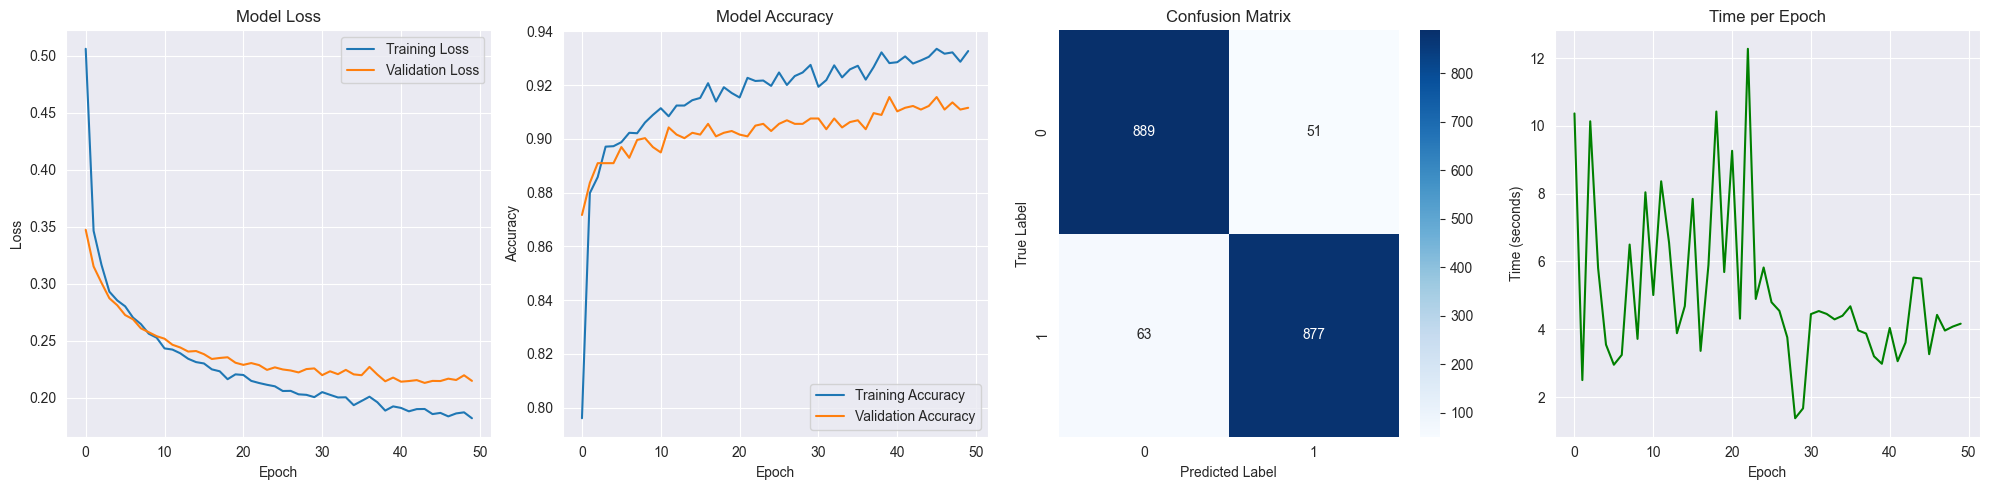

Accuracy: 0.9393617021276596
Precision: 0.9450431034482759
Recall: 0.9329787234042554
F1 Score: 0.9389721627408993
Total Training Time (s): 253.6907238960266
Average Epoch Time (s): 5.073814477920532
Classification Report:               precision    recall  f1-score   support

           0       0.93      0.95      0.94       940
           1       0.95      0.93      0.94       940

    accuracy                           0.94      1880
   macro avg       0.94      0.94      0.94      1880
weighted avg       0.94      0.94      0.94      1880

Epoch Times: [10.365924835205078, 2.5013442039489746, 10.134251594543457, 5.802930593490601, 3.5471208095550537, 2.9541122913360596, 3.242995500564575, 6.499037981033325, 3.7165210247039795, 8.04067873954773, 5.010089159011841, 8.364383935928345, 6.556983947753906, 3.88364315032959, 4.684001922607422, 7.847040176391602, 3.362457036972046, 5.897924184799194, 10.422334432601929, 5.687782526016235, 9.264082670211792, 4.313475847244263, 12.2724468708

In [12]:
# Main Execution
def main():
    filepath = r"C:\Users\HP\Documents\GitHub\ci-coursework\cleaned-stroke-prediction-dataset-balanced.csv"

    # Load and Preprocess Data
    X_train, X_test, y_train, y_test, scaler = load_and_preprocess_data(filepath)

    # Train Model
    model, history, epoch_time_callback = train_model(X_train, y_train)

    # Evaluate Model
    performance_metrics = evaluate_model(model, X_test, y_test, history, epoch_time_callback)

    # Print Performance Metrics
    for metric, value in performance_metrics.items():
        print(f"{metric}: {value}")


# Run the script
if __name__ == "__main__":
    main()